# SD201 : MINING OF LARGE DATASETS

## MUSIC GENRE CLASSIFICATION USING SONG LYRICS

In [188]:
# initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

### 1. CONSTRUCTION OF THE DATASET

The source of the dataset is a csv file : a result of a scrapping work through [GENIUS](https://genius.com/).

#### 1.1 ROW DATA EXPLORATION

In [189]:
# loading the dataset from csv file
data = pd.read_csv("lyrics.csv", sep='#')

In [190]:
# columns of dataset
data.columns

Index(['artist', 'title', 'lyrics', 'genre', 'url'], dtype='object')

In [191]:
# inspecting the content of the dataset
data.head()

,artist,title,lyrics,genre,url
0,Eminem,Rap God,"Rap God Lyrics\r\n""Look, I was gonna go easy o...",rap,https://genius.com/Eminem-rap-god-lyrics
1,Cardi B,WAP,WAP Lyrics\r\nWhores in this house\r\nThere's ...,rap,https://genius.com/Cardi-b-wap-lyrics
2,Kendrick Lamar,HUMBLE.,HUMBLE. Lyrics\r\nNobody pray for me\r\nIt bee...,rap,https://genius.com/Kendrick-lamar-humble-lyrics
3,Migos,Bad and Boujee,"Bad and Boujee Lyrics\r\nYou know, young rich ...",rap,https://genius.com/Migos-bad-and-boujee-lyrics
4,Drake,God's Plan,God’s Plan Lyrics\r\nAnd they wishin' and wish...,rap,https://genius.com/Drake-gods-plan-lyrics


In [192]:
# size of the dataset
data.shape

(6858, 5)

In [193]:
# types of data 
data.dtypes

artist    object
title     object
lyrics    object
genre     object
url       object
dtype: object

#### 1.2 ROW DATA CLEANING

In [194]:
#Missing values
data.isna().sum()[data.isna().sum() > 0]

lyrics    25
dtype: int64

In [195]:
# Deleting rows with missing values
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [196]:
#Check missing values (check is dropping went right)
data.isna().sum()


artist    0
title     0
lyrics    0
genre     0
url       0
dtype: int64

In [197]:
#deleting the "[title]-Lyrics" from the beginning of each lyrics and "[number xxx]Embed from the end"

for i in range(0,len(data['lyrics'])):
    
    data['lyrics'][i] = data['lyrics'][i].replace('.', '')
    data['lyrics'][i] = data['lyrics'][i].replace(',', '') #getting of dots and commas
    if(re.findall(r'\d+.*Embed.*', data['lyrics'][i])!=[]):
        data['lyrics'][i] = data['lyrics'][i].split(re.findall(r'\d+.*Embed.*', data['lyrics'][i])[0])[0]

    if (re.findall(r'\bLyrics\b', data['lyrics'][i])!=[]):
        data['lyrics'][i] = data['lyrics'][i].split('Lyrics')[1]
    

In [198]:
#Checking the data cleaning on a random song lyrics
print(data['lyrics'][1])


Whores in this house
There's some whores in this house
There's some whores in this house
There's some whores in this house (Hol' up)
I said certified freak seven days a week
Wet-ass pussy make that pullout game weak woo (Ah)

Yeah yeah yeah yeah
Yeah you fuckin' with some wet-ass pussy
Bring a bucket and a mop for this wet-ass pussy
Give me everything you got for this wet-ass pussy

Beat it up nigga catch a charge
Extra large and extra hard
Put this pussy right in your face
Swipe your nose like a credit card
Hop on top I wanna ride
I do a kegel while it's inside
Spit in my mouth look in my eyes
This pussy is wet come take a dive
Tie me up like I'm surprised
Let's roleplay I'll wear a disguise
I want you to park that big Mack truck right in this little garage
Make it cream make me scream
Out in public make a scene
I don't cook I don't clean
But let me tell you how I got this ring (Ayy ayy)
You might also like
Gobble me swallow me drip down the side of me (Yeah)
Quick jump out 'fore you

In [225]:
# Removing punctuation and stopwords from lyrics

from nltk import word_tokenize
from string import punctuation

punctuation = list(punctuation)

"""
THIS LIST HAS TO BE UPDATED : TOO MUCH WORDS
"""


# stopwords source : https://gist.github.com/sebleier/554280
stopwords = ["'d","'m","'s","'ve","'re","'ll",
             "0o", "0s", "3a", "3b", "3d", "6b", "6o", 
             "a", "a1", "a2", "a3", "a4","ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az",
             "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", 
             "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", 
             "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", 
             "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", 
             "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", 
             "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gon" , "gonna" , "gone", "got", "gotten", "gr", "greetings", "gs", "gy", 
             "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", 
             "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", 
             "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", 
             "l", "l2", "la","ll","largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", 
             "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", 
             "n", "n't", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", 
             "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", 
             "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", 
             "q", "qj", "qu", "que", "quickly", "quite", "qv", 
             "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", 
             "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", 
             "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there","there's", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", 
             "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", 
             "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", 
             "w", "wa", "want", "wanna" , "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", 
             "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", 
             "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", 
             "z", "zero", "zi", "zz",]


tokens_list = []
for i in range(len(data.lyrics)):
    tokens = ''
    tokens = word_tokenize(data.lyrics[i].lower())
    cleaned_tokens = ''
    cleaned_tokens = [token for token in tokens if token not in stopwords and token not in punctuation]
    data['lyrics'][i] = (" ".join(cleaned_tokens)).replace("`","").replace("''","")


In [226]:
# checking the data
data.tail()

,artist,title,lyrics,genre,url
6828,MAVI,Terms & Conditions,pro black relentlessly pursue money land guns ...,jazz,https://genius.com/Mavi-terms-and-conditions-l...
6829,Nina Simone,22nd Century,22nd century lyricsthere oxygen air men women ...,jazz,https://genius.com/Nina-simone-22nd-century-ly...
6830,Jon Batiste,CRY,love love love push shove feel feel feel real ...,jazz,https://genius.com/Jon-batiste-cry-lyrics
6831,Frank Sinatra,Once In Love With Amy,love amy lyricsonce love amy love amy fascinat...,jazz,https://genius.com/Frank-sinatra-once-in-love-...
6832,Frank Sinatra,Time After Time,time time lyricswhat good convey heart hear th...,jazz,https://genius.com/Frank-sinatra-time-after-ti...


#### 1.3 CLEANED ROW DATA VISUALISATION

Number of songs grouped by genre of music: genre
country     119
hip-hop    1000
jazz        979
metal       996
pop         739
r-b        1000
rap        1000
rock       1000
Name: lyrics, dtype: int64


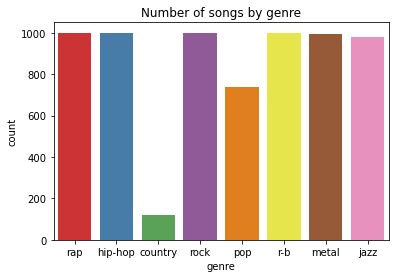

In [227]:
print("Number of songs grouped by genre of music:",data.groupby('genre').count()['lyrics'])
ax = plt.subplots()
ax = sns.countplot(x="genre", data = data, palette= "Set1")
ax.set_title("Number of songs by genre")
plt.show()

**Word clouds by genre:**

In [228]:
data_genre = data.genre.unique()

In [229]:
data_classified = []
for genre_lyrics in data_genre:
    lyrics_list = []
    for i in range(len(data.lyrics) ):
        if (data.genre[i]==genre_lyrics):
            lyrics_list.append(data.lyrics[i])
    data_classified.append(lyrics_list)

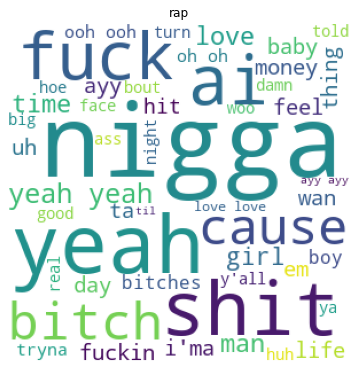

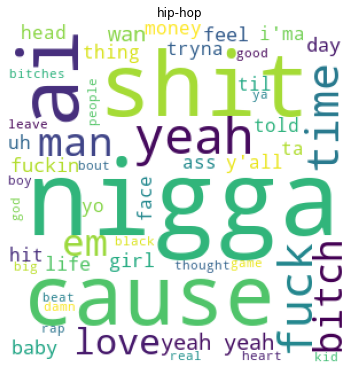

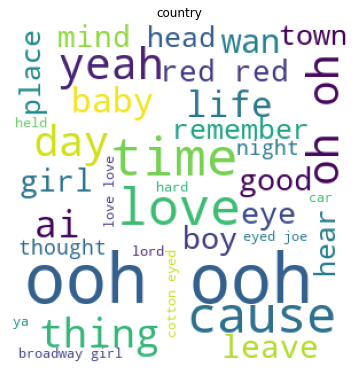

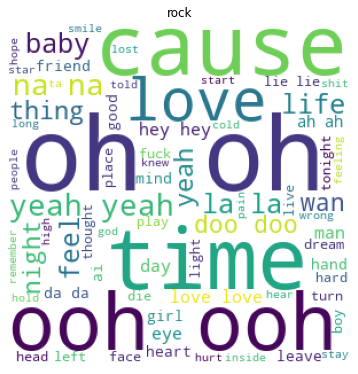

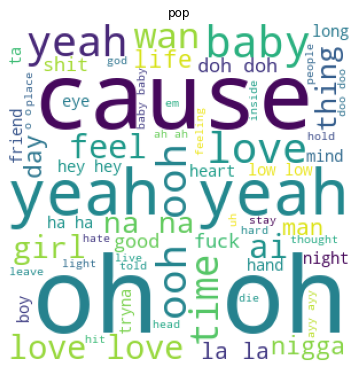

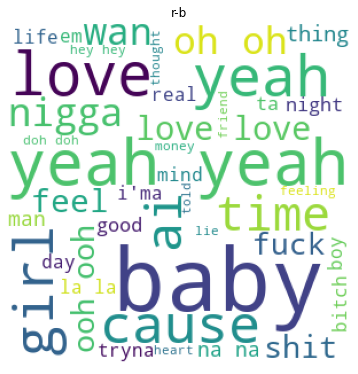

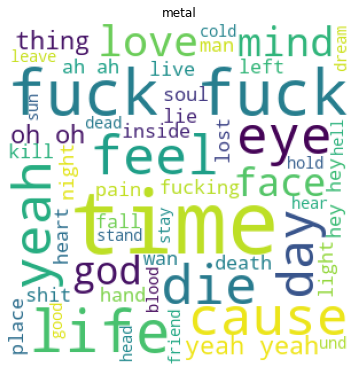

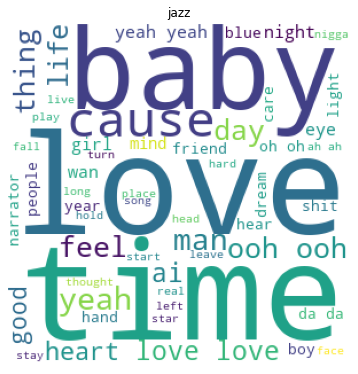

In [230]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

index_genre = 0 
#iterate through every music genre
for lyrics_of_genre in data_classified :

    wordcloud = WordCloud(width = 300, height = 300,background_color ='white', min_font_size = 10).generate(" ".join(lyrics_of_genre)+" ")
 
    # plot the WordCloud                       
    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(data_genre[index_genre])
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    # Save the image in the img folder:
    #wordcloud.to_file("img"+data_genre[index_genre]+"_words.png")
    index_genre +=1

### 2. DATA MODELING

#### 2.1 FEATURE SELECTION

In [152]:
# Selecting the columns for training
y = data.genre.values
x = data.lyrics.values

In [153]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)


In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
accuracies = {}
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(x_train, y_train)

r_accuracy = rf.score(x_test, y_test)*100
accuracies["Random Forest"] = r_accuracy
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(r_accuracy))

ValueError: could not convert string to float: "she urge but hold soggy clothes breezeblocks cetirizine fever ’ gripped never kisses send fullstops la do wild things they honey la break weep build breakfast now ’ eat love love love love la muscle muscle toe toe the fear gripped i my heart sinks i jump your hand grips hand eyes shut and i ah-ah-ah-ah do wild things they honey la break sleep build breakfast now ’ eat love love love love la she bruises coughs splutters pistol shots hold soggy clothes breezeblocks she ’ morphine queen vaccine my love love love love la you muscle muscle toe toe the fear gripped i my heart sinks i jump your hand grips hand eyes shut and i ah-ah-ah-aha aah-ah-ah-ah aah-ah-ah-ah-aha-i shhhh she urge but hold soggy clothes breezeblocks germolene disinfect scene love love love love but n't i love lovely please n't n't i love i love please n't n't i love i love please break heart hey please n't n't i love i love please n't n't i love i love please break heart please ’ i ’ eat i love i love i love please ’ i ’ eat i love i love please ’ i ’ eat i love i love i love please ’ i ’ eat i love i love please ’ i ’ eat i love i love i love please ’ i ’ eat i love i love please ’ i ’ eat i love i love i love please ’ i ’ eat i love i love"

### 3. RESULTS